In [186]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
#https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html

To explore time series models, we will continue with the Rossmann sales data. This dataset has sales data for sales at every Rossmann store for a 3-year period, as well indicators of holidays and basic store information.

In the last class, we saw that we would plot the sales data at a particular store to identify how the sales changed over time. Additionally, we computed autocorrelation for the data at varying lag periods. This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day? week? month?

In [187]:
import pandas as pd

# Load the data and set the DateTime index
data = pd.read_csv('../../../lessons/lesson-14/code/data/rossmann.csv', skipinitialspace=True, low_memory=False)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)
# Filter to Store 1
store1_data = data[data.Store == 1]

# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

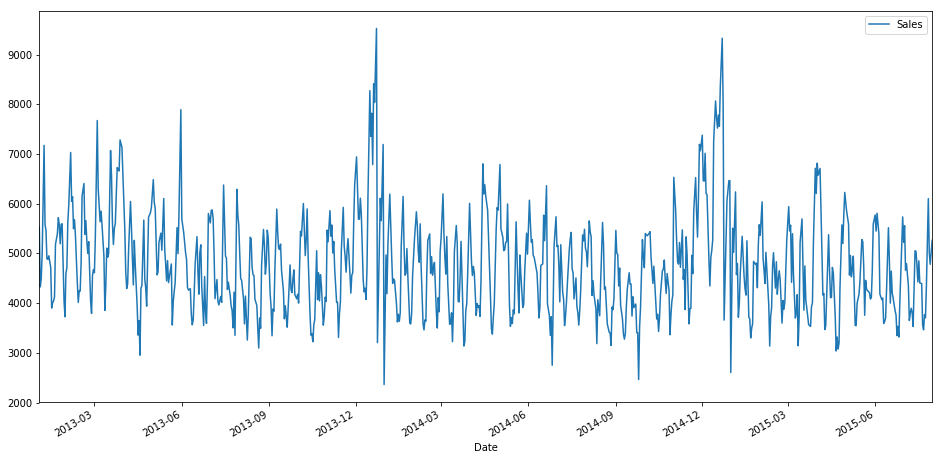

In [188]:
# Plot the sales over time
store1_open_data[['Sales']].plot(figsize=(16,8))

**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [189]:
store1_data.Sales.autocorr(lag=1) # -0.12

-0.12732514339140213

In [190]:
store1_data.Sales.autocorr(lag=2) # -0.03

-0.03478715570794693

Pandas and statsmodels both provide convenience plots for autocorrelations.

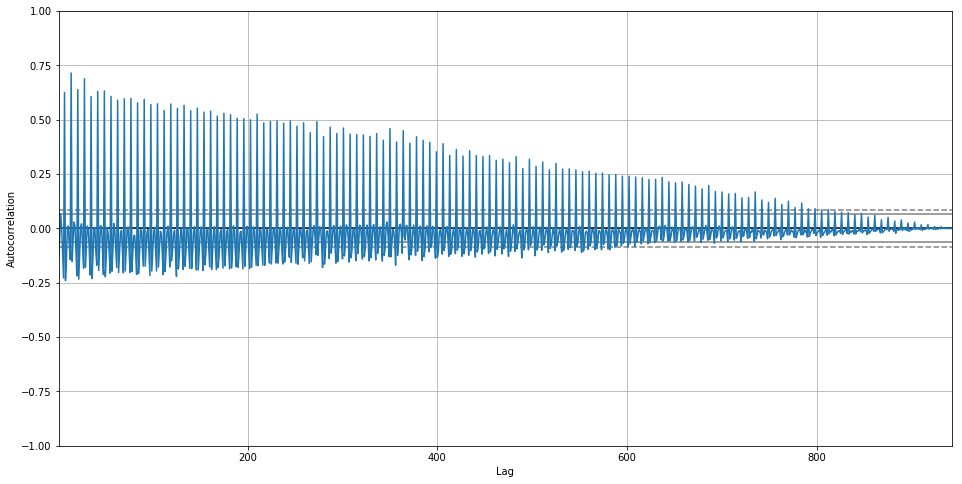

In [191]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(16,8))
autocorrelation_plot(store1_data.Sales)

In [192]:
#ACF values:
from statsmodels.tsa.stattools import acf
print(acf(store1_data.Sales, nlags=20))

[ 1.         -0.12703786 -0.03469319  0.06454937 -0.00180766 -0.10904274
 -0.22783504  0.6248786  -0.2401515  -0.14869745  0.00624578  0.01006485
 -0.07707318 -0.14363042  0.71435429 -0.15188393 -0.05551585  0.02901103
  0.01113764 -0.09400308 -0.21875595]


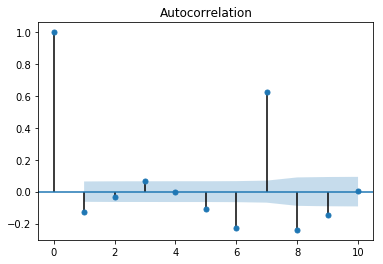

In [193]:
from statsmodels.graphics.tsaplots import plot_acf

g = plot_acf(store1_data.Sales, lags=10)
plt.show()

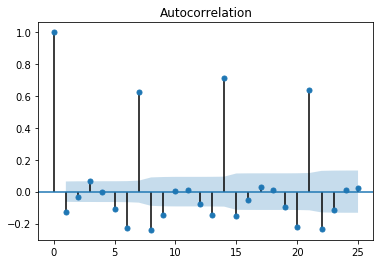

In [194]:
plot_acf(store1_data.Sales, lags=25)
plt.show()

**Check**: What caused the spike at 7?

# ARMA Model

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and a `MA(q)` model. So if we want just an `AR(p)` model we use and `ARMA(p, 0)` model. 

In [195]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)

model = ARMA(store1_sales_data, (1, 0)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Fri, 21 Jul 2017   AIC                          12540.651
Time:                        21:26:21   BIC                          12554.633
Sample:                    01-02-2013   HQIC                         12546.029
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.8241     82.986     57.393      0.000    4600.174    4925.474
ar.L1.Sales     0.6822      0.026     26.122      0.000       0.631       0.733
                                    Roots       

In [196]:
store1_sales_data.Sales.autocorr(1) 

0.68269082422794303

In [197]:
model = ARMA(store1_sales_data, (2, 0)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Fri, 21 Jul 2017   AIC                          12542.063
Time:                        21:26:21   BIC                          12560.705
Sample:                    01-02-2013   HQIC                         12549.233
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.2749     85.275     55.846      0.000    4595.139    4929.411
ar.L1.Sales     0.6634      0.036     18.537      0.000       0.593       0.734
ar.L2.Sales     0.0275      0.036      0.769    

Just like with other types of regression, we can compute the model residuals.

**Check**: What are residuals? In linear regression, what did we expect of residuals?

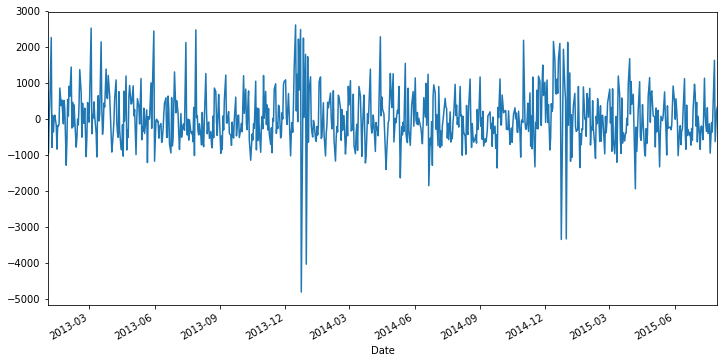

In [198]:
model.resid.plot(figsize=(12,6))

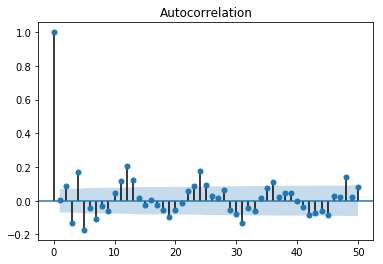

In [199]:
plot_acf(model.resid, lags=50)
plt.show()

Becuase of the errors, it doesn't look like an AR model is good enough -- the data isn't stationary. So let's expand to an `ARMA` model.

In [200]:
model = ARMA(store1_sales_data, (1, 1)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Fri, 21 Jul 2017   AIC                          12542.222
Time:                        21:26:21   BIC                          12560.865
Sample:                    01-02-2013   HQIC                         12549.392
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.8598     84.702     56.231      0.000    4596.846    4928.873
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654    

The ARMA model can also be created from ARIMA

In [201]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (1, 0, 1)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Fri, 21 Jul 2017   AIC                          12542.222
Time:                        21:26:22   BIC                          12560.865
Sample:                    01-02-2013   HQIC                         12549.392
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.8598     84.702     56.231      0.000    4596.846    4928.873
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654    

In [202]:
model = ARIMA(store1_sales_data, (1, 1, 1)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6261.011
Method:                       css-mle   S.D. of innovations            738.640
Date:                Fri, 21 Jul 2017   AIC                          12530.022
Time:                        21:26:22   BIC                          12548.660
Sample:                    01-03-2013   HQIC                         12537.190
                         - 07-31-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5108      0.364     -1.405      0.160      -1.223       0.202
ar.L1.D.Sales     0.6801      0.026     25.801      0.000       0.628       0.732
ma.L1.D.Sales    -1.0000      0.004   -2

In [203]:
model = ARIMA(store1_sales_data, (1, 1, 0)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6313.616
Method:                       css-mle   S.D. of innovations            792.680
Date:                Fri, 21 Jul 2017   AIC                          12633.233
Time:                        21:26:22   BIC                          12647.211
Sample:                    01-03-2013   HQIC                         12638.609
                         - 07-31-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1449     24.028     -0.006      0.995     -47.238      46.948
ar.L1.D.Sales    -0.1815      0.035     -5.150      0.000      -0.251      -0.112
                                    Root

In [204]:
store1_sales_data.Sales.diff(1).autocorr(1) 

-0.18144101447610664

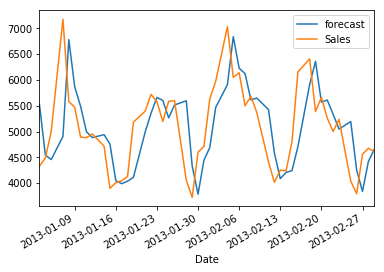

In [205]:
model.plot_predict(1, 50)
plt.show()

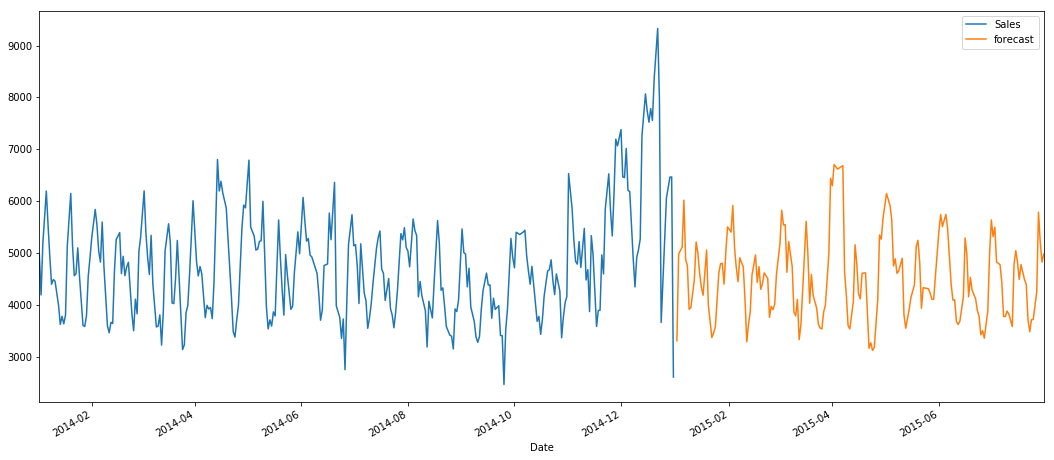

In [206]:
fig, ax = plt.subplots(figsize=(18,8))
ax = store1_sales_data['2014'].plot(ax=ax)
fig = model.plot_predict('2015-01-02', '2015-07-31', ax=ax, plot_insample=False)

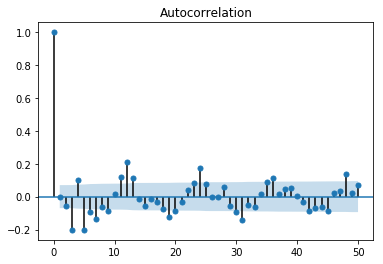

In [207]:
plot_acf(model.resid, lags=50)
plt.show()

Useful Links
- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#prerequisites
- http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/


### Facebook Prophet
- https://facebookincubator.github.io/prophet/docs/installation.html

In [209]:
# pip install fbprophet
from fbprophet import Prophet

In [210]:
m = Prophet()

In [215]:
store1_sales_data["y"] = store1_sales_data["Sales"]
store1_sales_data["ds"] = store1_sales_data.index

In [216]:
m.fit(store1_sales_data)

In [228]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1141,2016-07-26
1142,2016-07-27
1143,2016-07-28
1144,2016-07-29
1145,2016-07-30


In [229]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1141,2016-07-26,4417.565693,3305.474352,5503.941440
1142,2016-07-27,4279.952648,3195.417188,5373.158964
1143,2016-07-28,4167.558547,3109.365198,5200.073849
1144,2016-07-29,4397.043398,3316.799889,5489.702417
1145,2016-07-30,4575.541361,3457.800877,5629.387476


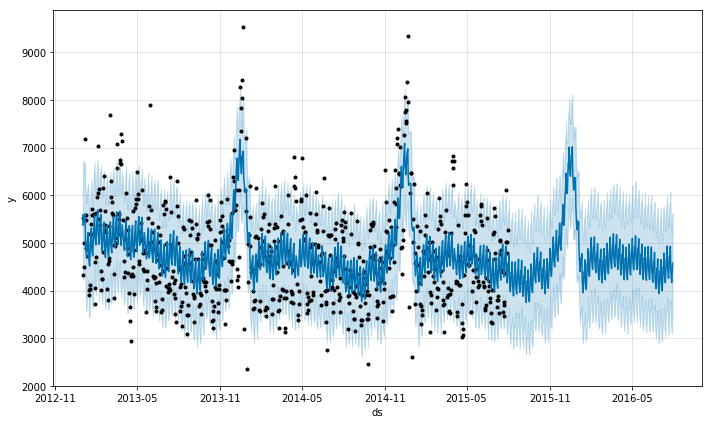

In [230]:
m.plot(forecast);

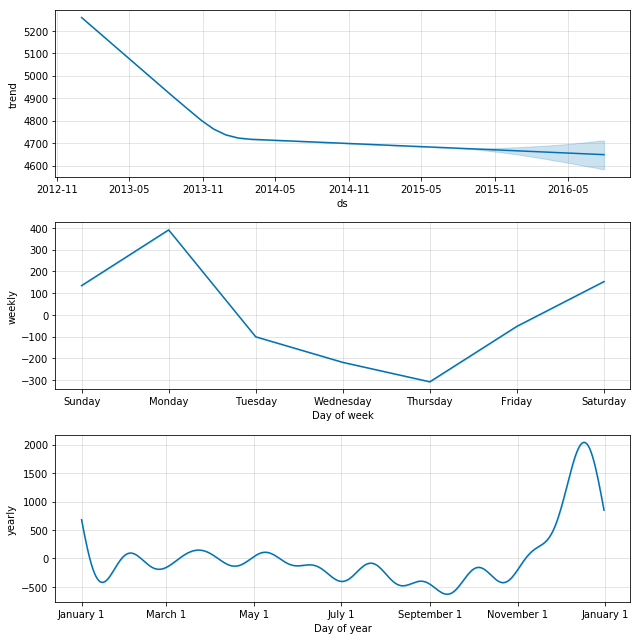

In [231]:
m.plot_components(forecast);

- https://research.fb.com/prophet-forecasting-at-scale/
- https://facebookincubator.github.io/prophet/docs/quick_start.html#python-api